# Probability
## Random number generators
In this notebook generating samples from various discrete random variables has been shown. All distributions are well-known and already implemented in Python. However, it is important to understand how random variables work and how to implement random number generators with different distributions.



### Binomial random number generator: modelling probability space
For the beginning, let's mplement the function `rbinom_fair(trials)` that generates one random number with binomial distribution for a given number of trials (tossings). Assume that a fair coin is used (i.e. probability of success (*head*) is 1/2). Let's use `itertools.product` to construct a sample set `omega`. Then  a function `X(outcome)` will be defined, that takes element `outcome` from `omega` and returns the value of the random variable for this outcome (i.e. counts number of *heads*). Then we will use `random.choice` to select random outcome from `omega` (note that `random.choice` and `numpy.random.choice` are different functions; we should use `random.choice` here because `numpy.random.choice` does not work with lists of tuples), calculate the value of `X` at this element and return it. The results of the function should be similar to the results of `scipy.stats.binom(trials, 0.5).rvs()`.

**Note.** This way of generating binomial random variable is extremely inefficient due to large sample space for large values of `trials`. In the next problem we discuss mode efficient way to do it. This example is for educational purposes only: it illustrates the definition of random variable as a function defined on probability space.

In [56]:
import random
import matplotlib.pyplot as plt
from itertools import product
from numpy.random import choice

from scipy.stats import binom
from scipy.special import comb
from scipy.stats import geom

In [10]:
def rbinom_fair(trials):
    omega = list(product("HT", repeat=trials))
    def X(outcome):
        return outcome.count("H")
    outcome = random.choice(omega)
    return X(outcome)

Try running it. Should obtain random number. If you run this cell again, you will get different number.

In [13]:
print(rbinom_fair(10))

5


I'm going to implement two auxiliary functions to draw barplots of empirical frequencies and compare them with the corresponding probability mass functions.

In [20]:
def count_frequencies(data, relative=False):
    counter = {}
    for element in data:
        if element not in counter:
            counter[element] = 1
        else:
            counter[element] += 1
    if relative:
        for element in counter:
            counter[element] /= len(data)
    return counter
    
def sample_bar_plot(data, ax=None):
    if ax is None:
        ax = plt.gca()
    freqs = count_frequencies(data, relative=True)
    ax.bar(freqs.keys(), freqs.values())
    ax.set_xticks(list(freqs.keys()))
    return ax

Let us first generate a sample from `scipy.stats.binom` and visualize it.

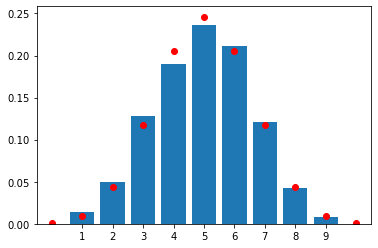

In [35]:
trials = 10
size = 1000

sample = [binom(trials, 0.5).rvs() for _ in range(size)]

sample_bar_plot(sample)
plt.plot(range(trials + 1), binom(trials, 0.5).pmf(range(trials + 1)), 'o', color='red')
plt.show()

If we would use `rbinom_fair` instead of `binom(trials, 0.5).rvs()` in the code above, we had to obtain a similar result. Let me write a test function to compare results of our implementation and reference one.

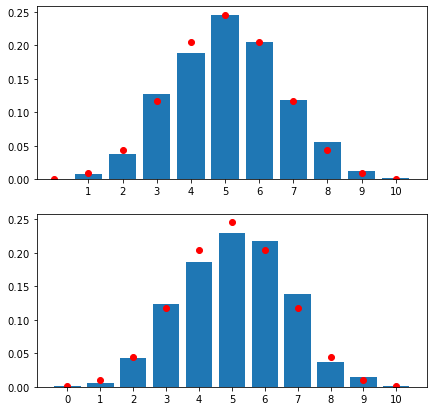

In [36]:
def two_pictures_rbinom_fair(trials, size):
    plt.figure(figsize=(7, 7))
    plt.subplot(211)
    
    sample = [binom(trials, 0.5).rvs() for _ in range(size)]

    sample_bar_plot(sample)
    plt.plot(range(trials + 1), binom(trials, 0.5).pmf(range(trials + 1)), 'o', color='red')
    
    plt.subplot(212)
    try:
        sample = [rbinom_fair(trials) for _ in range(size)]
        sample_bar_plot(sample)
        plt.plot(range(trials + 1), binom(trials, 0.5).pmf(range(trials + 1)), 'o', color='red')
    except (NameError, TypeError) as e:
        raise Error("Function rbinom_fair is not yet implemented")
        
two_pictures_rbinom_fair(10, 1000)

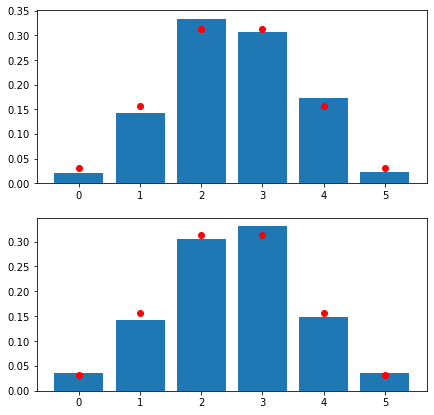

In [37]:
two_pictures_rbinom_fair(5, 1000)

### Binomial random number generator: explicit formula
Let's use `numpy.random.choice` to implement function `rbinom(trials, prob, size)` that samples binomially distributed random variable with given number of trials (*tosses*) and probability of success (*head*) and returns a sample of size `size`. We should pass an array that contains all possible values that this random variable can take as a first argument of `numpy.random.choice` and their respective probabilities (i.e. values of probability mass function) as a second argument. To find probabilities, you can use the formula that is discussed in videos. You can use `scipy.special.comb` to find binomial coefficients. The results of your function should be similar to the results of `scipy.stats.binom(trials, prob).rvs(size)`. You can test your function by generating large samples and plotting frequencies like discussed in the video.

In [42]:
def rbinom(trials, prob, size):
    pb = [comb(trials, i, exact=True) * (prob ** i) * ((1 - prob) ** (trials - i)) for i in range(trials+1)]
    return choice(trials+1, p=pb, size=size)
    

Try running it: should obtain `array` of numbers.

In [43]:
rbinom(10, 0.3, 5) # expecting something like `array([4, 1, 3, 2, 1])`

array([4, 3, 3, 2, 2])

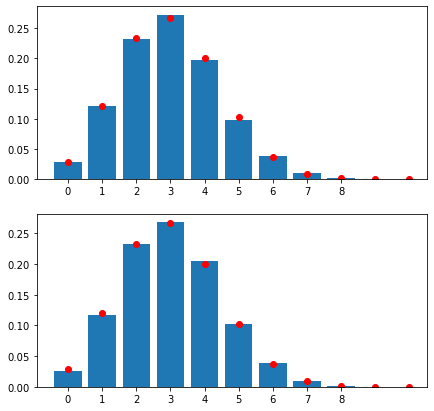

In [44]:
def two_pictures_rbinom(trials, prob, size):
    def draw_sample(sample, trials, prob):
        sample_bar_plot(sample)
        plt.plot(range(trials + 1), binom(trials, prob).pmf(range(trials + 1)), 'o', color='red')
    plt.figure(figsize=(7, 7))
    plt.subplot(211)
    draw_sample(binom(trials, prob).rvs(size), trials, prob)
    plt.subplot(212)
    try:
        draw_sample(rbinom(trials, prob, size), trials, prob)
    except (NameError, TypeError):
        raise Exception("rbinom is not implemented or other error occurred")

two_pictures_rbinom(10, 0.3, 10000)

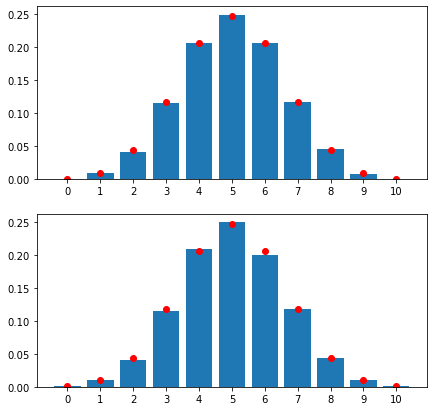

In [45]:
two_pictures_rbinom(10, 0.5, 10000)

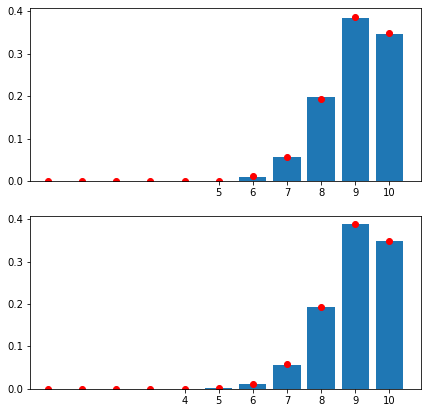

In [46]:
two_pictures_rbinom(10, 0.9, 10000)

### Binomial random number generator: sum of Bernoulli random variables
Finally, consider another way to generate binomial random variables. Consider Bernoulli random variable. It takes value 1 with probability $p$ and value 0 with probability $1-p$. Assume that $X_1, \ldots, X_n$ are independent Bernoulli random variables. They can be considered as realizations of independent coin tossings (if coin lands *head*, we write 1, otherwise write 0; probability of *head* is $p$). Then $Y=X_1 + \ldots + X_n$ is a binomial random variable with $n$ trials and probability of success $p$. Let us use this approach to generate binomial random variable.

Write a function `rbinom_with_bernoulli(trials, prob)` that generates `trials` independent Bernoulli random variables with parameter $p=prob$ and returns its sum. To generate Bernoulli random variable, use the `numpy.random.choice` function. Independent runs of this function will generate independent Bernoulli random variables.

In [47]:
def rbinom_with_bernoulli(trials, prob):
    return choice(2, trials, p=[1-prob, prob]).sum()

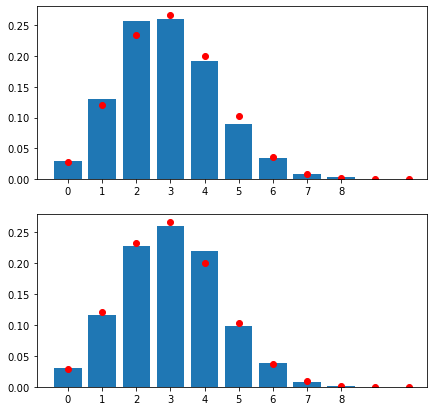

In [48]:
def two_pictures_rbinom_with_bernoulli(trials, prob, size):
    def draw_sample(sample, trials, prob):
        sample_bar_plot(sample)
        plt.plot(range(trials + 1), binom(trials, prob).pmf(range(trials + 1)), 'o', color='red')
    plt.figure(figsize=(7, 7))
    plt.subplot(211)
    draw_sample(binom(trials, prob).rvs(size), trials, prob)
    plt.subplot(212)
    try:
        draw_sample([rbinom_with_bernoulli(trials, prob) for _ in range(size)], trials, prob)
    except (NameError, TypeError):
        raise Exception("rbinom_with_bernoulli is not implemented or other error occurred")

two_pictures_rbinom_with_bernoulli(10, 0.3, 1000)

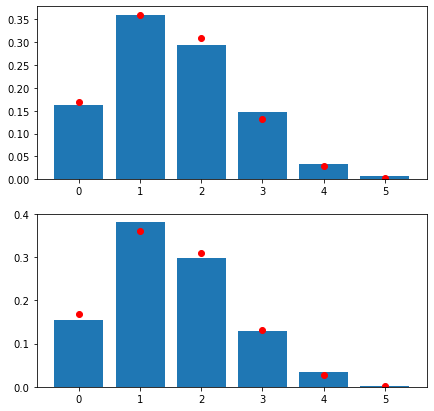

In [50]:
two_pictures_rbinom_with_bernoulli(5, 0.3, 1000)

### Geometric random number generator
Let's implement a function `rgeom(p)` that generates one geometrically distributed random variable with probability of success `p`. Instead of using explicit formula for the probability, we'll use the definition of geometric distribution: toss a virtual coin until first *head* appears, then return number of tosses (including the one with *head*). We can model this coin using `numpy.random.choice` function with appropriate `p` parameter. Check that results are similar to ones generated with `scipy.stats.geom(p).rvs()`.

In [64]:
def rgeom(prob):
    res = 0
    count = 0
    while res == False:
        res = choice(2, p=[1-prob, prob])
        count += 1
    return count

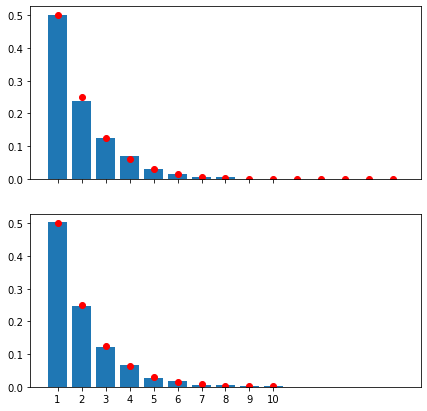

In [65]:
def two_pictures_rgeom(p, size):
    def draw_sample(sample, p, ax):
        sample_bar_plot(sample, ax)
        x = range(1, max(sample) + 1)
        ax.plot(x, geom(p).pmf(x), 'o', color='red')
    _, axes = plt.subplots(2, 1, sharex=True, figsize=(7, 7))
    draw_sample([geom(p).rvs() for _ in range(size)], p, axes[0])
    try:
        draw_sample([rgeom(p) for _ in range(size)], p, axes[1])
    except (NameError, TypeError):
        raise Exception("rbinom_with_bernoulli is not implemented or other error occurred")
two_pictures_rgeom(0.5, 1000)

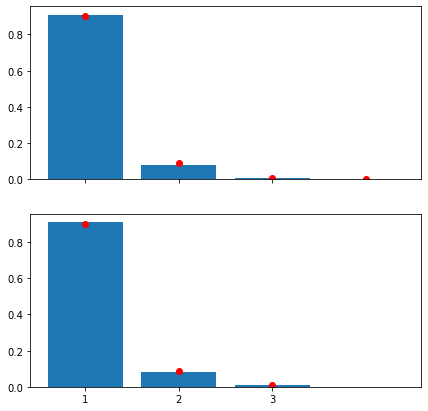

In [66]:
two_pictures_rgeom(0.9, 1000)

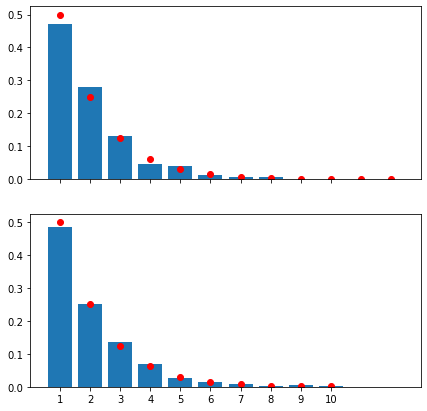

In [67]:
two_pictures_rgeom(0.5, 1000)

## That's all
Now you know that there are different ways to construct random variables with given distributions.